## Домашняя работа к Уроку 2
### Студент: Абрамов А.В.

In [12]:
import pandas as pd

Наши новости

In [13]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [14]:
news.loc[26000].title

'Принтер, печатающий специальными чернилами, которые впоследствии можно стереть, что позволяет использовать один и тот же бумажный лист многократно, разработан в Японии.nРазработка состоит из двух аппаратов: один — одновременно принтер, копировальный аппарат, факс и сканер — печатает и копирует документы с помощью специальных чернил.nДругой механизм стирает ставший ненужным текст старого документа, возвращая бумаге ее первоначальный вид. Прибор также может предварительно отсканировать текст и отправить его в память компьютера и лишь затем стереть документ.nnСистема аппаратов Loops позволяет экономить до 80% бумаги и рассчитана на предприятия и фирмы, заинтересованные в экономии средств на расходные материалы.nLoops поступит на японский рынок уже в феврале будущего года. Цена двух аппаратов составит около 17 тысяч долларов. Компания Toshiba Tec намерена в год продавать не менее 5 тысяч таких комплектов.'

Загрузим пользователей и списки последних прочитанных новостей

In [15]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [16]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [20]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [21]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [22]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\User\AppData\Local\Temp\ipykernel_9540\2296537027.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: total: 21 s
Wall time: 21 s


In [23]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: total: 2min 34s
Wall time: 2min 34s


А теперь в 3 строчки обучим нашу модель

In [24]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [25]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [26]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: total: 39.2 s
Wall time: 37.4 s


In [27]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [28]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.38432628),
 (5, 0.043183688),
 (7, 0.15838943),
 (9, 0.123621576),
 (19, 0.27261317)]

In [29]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год который это научный ракета мочь мозг
topic_1: год население это пенсия форум солнце день
topic_2: это украина год власть дело санкция который
topic_3: разместить возраст выдать флот берег еда лётчик
topic_4: который год это человек мочь время свой
topic_5: космос расчёт площадь вследствие снежный осадка товарищ
topic_6: это экономика наука банк россия строительство доля
topic_7: россия российский это год который президент nn
topic_8: район nn москва военный год день программа
topic_9: это который свой всё мочь россия сказать
topic_10: газ лаборатория квартира польша польский визит эволюция
topic_11: год суд банк который это решение дело
topic_12: год обнаружить стать день университет женщина выяснить
topic_13: год это новый сша проект компания рынок
topic_14: погибнуть страна это nn который операция министерство
topic_15: билет проявление тереза краткий химик квадратный луценко
topic_16: год фонд компания рубль ребёнок nn который
topic_17: смерть полоса употребление кг вес

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [30]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [31]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.645605,0.034584,0.000000,...,0.0,0.18989,0.0,0.0,0.033807,0.0,0.0,0.020595,0.0,0.000000
1,4896,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.00000,0.0,0.0,0.223860,0.0,0.0,0.000000,0.0,0.651342
2,4897,0.387124,0.000000,0.0,0.0,0.000000,0.04324,0.000000,0.159811,0.000000,...,0.0,0.00000,0.0,0.0,0.272746,0.0,0.0,0.000000,0.0,0.000000
3,4898,0.000000,0.000000,0.0,0.0,0.430442,0.00000,0.000000,0.000000,0.000000,...,0.0,0.00000,0.0,0.0,0.125805,0.0,0.0,0.000000,0.0,0.000000
4,4899,0.000000,0.229281,0.0,0.0,0.000000,0.00000,0.000000,0.361054,0.154767,...,0.0,0.00000,0.0,0.0,0.059028,0.0,0.0,0.000000,0.0,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [32]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [33]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [34]:
doc_dict[293622]

array([0.03190153, 0.10937009, 0.        , 0.        , 0.20071669,
       0.        , 0.        , 0.20676975, 0.03881469, 0.        ,
       0.        , 0.        , 0.32544705, 0.        , 0.        ,
       0.        , 0.07604454, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [35]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [36]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

### 3. Повторить п.2, но используя уже не медиану, а max

In [37]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [72]:
get_user_embedding_max(user_articles_list)

array([0.21619211, 0.        , 0.44589373, 0.01520153, 0.43473336,
       0.03774767, 0.05065482, 0.52657831, 0.34584737, 0.58235681,
       0.05853447, 0.21400629, 0.03708328, 0.31842425, 0.0349615 ,
       0.        , 0.2271191 , 0.        , 0.        , 0.01051925,
       0.        , 0.        , 0.        , 0.07546645, 0.07623567])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [73]:
#users['articles'].iloc[33]

In [74]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [75]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.116578,0.109370,0.250852,0.000000,0.280065,0.00000,0.062065,0.323452,0.092809,...,0.0,0.573966,0.044657,0.04084,0.058966,0.00000,0.0,0.000000,0.075881,0.106911
1,u108690,0.214376,0.114870,0.329768,0.000000,0.295005,0.00000,0.050158,0.342147,0.089763,...,0.0,0.211277,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,0.061307,0.087026
2,u108339,0.107074,0.039614,0.227706,0.010805,0.320126,0.01399,0.021151,0.351200,0.334556,...,0.0,0.293714,0.000000,0.00000,0.013033,0.01513,0.0,0.036846,0.047139,0.065482


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [76]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [77]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.116578,0.109370,0.250852,0.000000,0.280065,0.00000,0.062065,0.323452,0.092809,...,0.573966,0.044657,0.04084,0.058966,0.00000,0.0,0.000000,0.075881,0.106911,0
1,u108690,0.214376,0.114870,0.329768,0.000000,0.295005,0.00000,0.050158,0.342147,0.089763,...,0.211277,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,0.061307,0.087026,1
2,u108339,0.107074,0.039614,0.227706,0.010805,0.320126,0.01399,0.021151,0.351200,0.334556,...,0.293714,0.000000,0.00000,0.013033,0.01513,0.0,0.036846,0.047139,0.065482,1


In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [79]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [80]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [81]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.17847939, 0.01252443, 0.78020545, 0.15868905, 0.02058434,
       0.02569816, 0.43059328, 0.06656271, 0.00275943, 0.16248912])

In [82]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [83]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

f_score_metrix = fscore[ix]
precision_metrix = precision[ix]
recall_metrix = recall[ix]


print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.337865, F-Score=0.697, Precision=0.704, Recall=0.690


In [84]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1684   71]
 [  77  168]]


NameError: name 'itertools' is not defined

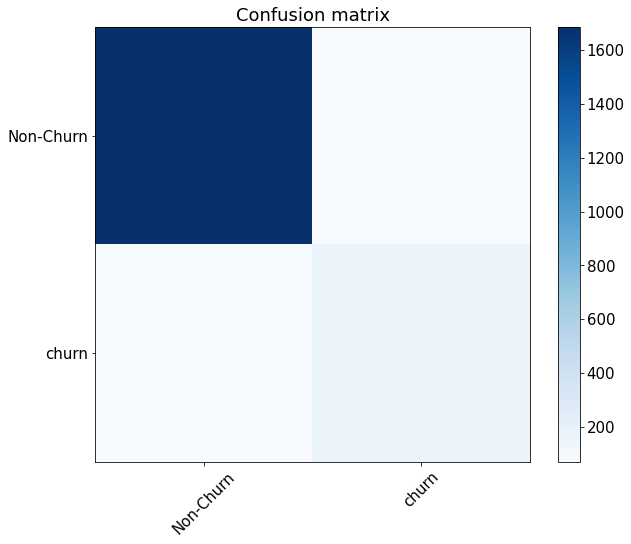

In [85]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [86]:
roc_auc_metrix = roc_auc_score(y_test, preds)

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### 5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [87]:
#metrix = {'roc_auc':[], 'precision':[], 'recall':[], 'f_score':[]}

In [88]:
metrix['roc_auc'].append(roc_auc_metrix)
metrix['precision'].append(precision_metrix)
metrix['recall'].append(recall_metrix)
metrix['f_score'].append(f_score_metrix)

metrix

{'roc_auc': [0.9122949008663293, 0.9604395604395604, 0.9542089656375372],
 'precision': [0.4691689008042895, 0.6076696165191741, 0.7041666666666667],
 'recall': [0.7142857142857143, 0.8408163265306122, 0.689795918367347],
 'f_score': [0.5663430420711975, 0.7054794520547946, 0.6969072164948453]}

In [89]:
metrix_table = pd.DataFrame(metrix, index=['mean', 'median', 'max'])

In [90]:
metrix_table

,roc_auc,precision,recall,f_score
mean,0.912295,0.469169,0.714286,0.566343
median,0.960440,0.607670,0.840816,0.705479
max,0.954209,0.704167,0.689796,0.696907


### 6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Вспоминаем, что Precision отвечает за то, чтобы не выбрать неправильные элементы, даже если правильные пропустятся. Recall же наоборот, отвечает за то, чтобы не пропустить правильные, даже если при этом будут выбраны неправильные элементы. Чем выше Precision и Recall, тем лучше, но в реальности нельзя максимизировать оба показателя сразу, необходим баланс. 

По таблице matrix_table видно, что максимальная точность (Precision) достигается при методе эмбендинга с max, но при этом отмечается минимальная полнота (Recall). При методе же эмбендинга с mean наблюдается минимальная точность с полнотой, не намного превышающей метод эмбендинг с max. При этом объединяющая в себе информацию о точности и полноте алгоритма, метрика F-score максимальна при методе эмбендинга с median. Использование медианы также дает максимальное значение ROC AUC (площадь под кривой ошибок), что говорит о более высоком качестве упорядочивания объектов алгоритмов.

Таким образом, получается, что из вариантов mean, median, max предпочтительным вариантом преобразования данных при эмбендинге является вычисление медианы. А вот вычисление среднего арифметического оказалось самым непродуктивным. Возможно, это связано с тем, что в большинстве случаев подобных задач, среднее значение обладает низкой информативностью, в сравнении с медианой.


### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk